In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import vstack, hstack
import myfm

# Load data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_cil(dataset="split"):

    file = "data_train" if dataset != "test" else "sampleSubmission"
    data = pd.read_csv(f'../data/{file}.csv', index_col=0)
    data['user'] = data.index.str.split('_').str[0].str[1:].astype('int32')
    data['movie'] = data.index.str.split('_').str[1].str[1:].astype('int32')
    data.rename(columns={'Prediction': 'rating'}, inplace=True)
    data['rating'] = data['rating'].astype('uint8')
    data = data[['user', 'movie', 'rating']]

    data['user'] = data['user'] - 1
    data['movie'] = data['movie'] - 1
    print("Subtracted {} from user and movie".format(1))

    user_num = 10000  # int(data['user'].max() + 1)
    movie_num = 1000  # int(data['movie'].max() + 1)
    print("User num: {}, Movie num: {}".format(user_num, movie_num))

    train_data = val_data = None
    if dataset == "test":
        val_data = data
    elif dataset == "train":
        train_data = data
    else:
        train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    return train_data, val_data, user_num, movie_num

In [3]:
train_data, val_data, user_num, movie_num = load_cil("split")

Subtracted 1 from user and movie
User num: 10000, Movie num: 1000


# One hot encoding

In [4]:
FEATURE_COLUMNS = ['user', 'movie']
ohe = OneHotEncoder(handle_unknown='ignore')

X_train = ohe.fit_transform(train_data[FEATURE_COLUMNS])
X_test = ohe.transform(val_data[FEATURE_COLUMNS])
y_train = train_data.rating.values
y_test = val_data.rating.values

In [5]:
X_train.shape

(941561, 11000)

In [6]:
FM_RANK = 10
N_ITER = 200
N_KEPT_SAMPLES = 200
fm_grouped_0 = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_grouped_0.fit(
    X_train, y_train, n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES,
    group_shapes=[len(group) for group in ohe.categories_]
)
prediction_grouped = fm_grouped_0.predict(X_test)
prediction_grouped = np.clip(prediction_grouped, 1, 5)
rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
mae = np.abs(y_test - prediction_grouped).mean()
print(f'rmse={rmse}, mae={mae}')

alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


rmse=0.9797415528913666, mae=0.7833792304512732


# Split for active learning

In [7]:
X_train, X_train_add, y_train, y_train_add = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [8]:
print(X_train.shape, X_train_add.shape, y_train.shape, y_train_add.shape)

(470780, 11000) (470781, 11000) (470780,) (470781,)


# BFM

In [9]:
STEP_SIZE = 10000

In [10]:
fm_grouped = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_grouped.fit(
    X_train, y_train, n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES,
    group_shapes=[len(group) for group in ohe.categories_]
)
prediction_grouped = fm_grouped.predict(X_test)
prediction_grouped = np.clip(prediction_grouped, 1, 5)
rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
mae = np.abs(y_test - prediction_grouped).mean()
print(f'rmse={rmse}, mae={mae}')

alpha = 1.18 w0 = 3.80 : 100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


rmse=0.9943664744139579, mae=0.7997400849083295


In [11]:
iterations = np.ceil(train_data.shape[0] / 2 / STEP_SIZE).astype('int32')
rmse_array = [rmse]
train_percentage_array = [0.5]
for i in range(iterations):
    # train on 1000 random samples more
    sample = np.random.choice(X_train_add.shape[0], STEP_SIZE, replace=False) if X_train_add.shape[0] > STEP_SIZE else np.arange(X_train_add.shape[0])
    X_train = vstack((X_train, X_train_add[sample]))
    y_train = hstack((y_train,  y_train_add[sample])).toarray().reshape(-1)

    # remove from X_train_add
    X_train_add = X_train_add[np.setdiff1d(np.arange(X_train_add.shape[0]), sample)]
    y_train_add = y_train_add[np.setdiff1d(np.arange(y_train_add.shape[0]), sample)]

    print(X_train.shape, X_train_add.shape, y_train.shape, y_train_add.shape)

    fm_grouped.fit(
        X_train, y_train, n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES,
        group_shapes=[len(group) for group in ohe.categories_]
    )

    prediction_grouped = fm_grouped.predict(X_test)
    prediction_grouped = np.clip(prediction_grouped, 1, 5)
    rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
    mae = np.abs(y_test - prediction_grouped).mean()
    print(f'rmse={rmse}, mae={mae}')

    rmse_array.append(rmse)
    train_percentage_array.append(X_train.shape[0] / (X_train.shape[0] + X_train_add.shape[0]))

(480780, 11000) (460781, 11000) (480780,) (460781,)


alpha = 1.17 w0 = 3.81 : 100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


rmse=0.9937742087784031, mae=0.7991409090044441
(490780, 11000) (450781, 11000) (490780,) (450781,)


alpha = 1.17 w0 = 3.81 : 100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


rmse=0.9933796452876268, mae=0.79865502729801
(500780, 11000) (440781, 11000) (500780,) (440781,)


alpha = 1.17 w0 = 3.80 : 100%|██████████| 200/200 [00:16<00:00, 12.31it/s]


rmse=0.9928502081631028, mae=0.7981216809526491
(510780, 11000) (430781, 11000) (510780,) (430781,)


alpha = 1.17 w0 = 3.80 : 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


rmse=0.9923156815853258, mae=0.7976111877928131
(520780, 11000) (420781, 11000) (520780,) (420781,)


alpha = 1.17 w0 = 3.80 : 100%|██████████| 200/200 [00:16<00:00, 12.11it/s]


rmse=0.9920230238382145, mae=0.7970972953668848
(530780, 11000) (410781, 11000) (530780,) (410781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:17<00:00, 11.35it/s]


rmse=0.9918215163069926, mae=0.7967873336707373
(540780, 11000) (400781, 11000) (540780,) (400781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


rmse=0.991157624098688, mae=0.7962332325530023
(550780, 11000) (390781, 11000) (550780,) (390781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


rmse=0.9908905352052553, mae=0.7959404443547169
(560780, 11000) (380781, 11000) (560780,) (380781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:18<00:00, 10.84it/s]


rmse=0.9906760953360573, mae=0.7956627524485302
(570780, 11000) (370781, 11000) (570780,) (370781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:18<00:00, 10.73it/s]


rmse=0.9903211612925668, mae=0.7952582156493504
(580780, 11000) (360781, 11000) (580780,) (360781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:19<00:00, 10.34it/s]


rmse=0.990114982764725, mae=0.7950056723730035
(590780, 11000) (350781, 11000) (590780,) (350781,)


alpha = 1.16 w0 = 3.80 : 100%|██████████| 200/200 [00:19<00:00, 10.24it/s]


rmse=0.9898171040322055, mae=0.7946726117857852
(600780, 11000) (340781, 11000) (600780,) (340781,)


alpha = 1.16 w0 = 3.79 : 100%|██████████| 200/200 [00:19<00:00, 10.05it/s]


rmse=0.9895806060323213, mae=0.7944471127101501
(610780, 11000) (330781, 11000) (610780,) (330781,)


alpha = 1.16 w0 = 3.79 : 100%|██████████| 200/200 [00:19<00:00, 10.00it/s]


rmse=0.9892104377178554, mae=0.7939713962463159
(620780, 11000) (320781, 11000) (620780,) (320781,)


alpha = 1.16 w0 = 3.79 : 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


rmse=0.9889215853463094, mae=0.7935489387121942
(630780, 11000) (310781, 11000) (630780,) (310781,)


alpha = 1.16 w0 = 3.79 : 100%|██████████| 200/200 [00:20<00:00,  9.63it/s]


rmse=0.9887626276014589, mae=0.7933618428161101
(640780, 11000) (300781, 11000) (640780,) (300781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:21<00:00,  9.32it/s]


rmse=0.9886875346218169, mae=0.7931363680867585
(650780, 11000) (290781, 11000) (650780,) (290781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:22<00:00,  9.00it/s]


rmse=0.9880818430189754, mae=0.792512680606547
(660780, 11000) (280781, 11000) (660780,) (280781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


rmse=0.9876562770530904, mae=0.7919520403621939
(670780, 11000) (270781, 11000) (670780,) (270781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:22<00:00,  8.76it/s]


rmse=0.9869691474372154, mae=0.7912543184642954
(680780, 11000) (260781, 11000) (680780,) (260781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:23<00:00,  8.65it/s]


rmse=0.9866659474860904, mae=0.7908868341586041
(690780, 11000) (250781, 11000) (690780,) (250781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:23<00:00,  8.54it/s]


rmse=0.9864208090075443, mae=0.7906362872011381
(700780, 11000) (240781, 11000) (700780,) (240781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:23<00:00,  8.40it/s]


rmse=0.9860427279068921, mae=0.7903004288686639
(710780, 11000) (230781, 11000) (710780,) (230781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:24<00:00,  8.25it/s]


rmse=0.9858267448131347, mae=0.790071966170437
(720780, 11000) (220781, 11000) (720780,) (220781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:24<00:00,  8.10it/s]


rmse=0.9854214664261862, mae=0.7896821283431174
(730780, 11000) (210781, 11000) (730780,) (210781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:25<00:00,  7.97it/s]


rmse=0.9851433331055669, mae=0.7892879874987239
(740780, 11000) (200781, 11000) (740780,) (200781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:25<00:00,  7.82it/s]


rmse=0.9850135478925908, mae=0.7890318055934871
(750780, 11000) (190781, 11000) (750780,) (190781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:25<00:00,  7.73it/s]


rmse=0.984374388665021, mae=0.7884742715235419
(760780, 11000) (180781, 11000) (760780,) (180781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:26<00:00,  7.63it/s]


rmse=0.98406323373421, mae=0.7881031494736558
(770780, 11000) (170781, 11000) (770780,) (170781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


rmse=0.983665825178231, mae=0.7878213955425798
(780780, 11000) (160781, 11000) (780780,) (160781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:27<00:00,  7.31it/s]


rmse=0.9838344561624207, mae=0.7878955043428875
(790780, 11000) (150781, 11000) (790780,) (150781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:27<00:00,  7.21it/s]


rmse=0.9832150109132967, mae=0.7873422617279306
(800780, 11000) (140781, 11000) (800780,) (140781,)


alpha = 1.14 w0 = 3.80 : 100%|██████████| 200/200 [00:27<00:00,  7.16it/s]


rmse=0.9829912980886356, mae=0.7871222950059641
(810780, 11000) (130781, 11000) (810780,) (130781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:28<00:00,  7.10it/s]


rmse=0.9829861754238963, mae=0.7870147690026026
(820780, 11000) (120781, 11000) (820780,) (120781,)


alpha = 1.14 w0 = 3.78 : 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


rmse=0.9823011086750175, mae=0.7863159685858405
(830780, 11000) (110781, 11000) (830780,) (110781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:28<00:00,  6.91it/s]


rmse=0.9820294914617435, mae=0.7860214280704867
(840780, 11000) (100781, 11000) (840780,) (100781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


rmse=0.9817383031045004, mae=0.7857190673163813
(850780, 11000) (90781, 11000) (850780,) (90781,)


alpha = 1.14 w0 = 3.80 : 100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


rmse=0.9815328878550809, mae=0.785449658523112
(860780, 11000) (80781, 11000) (860780,) (80781,)


alpha = 1.14 w0 = 3.80 : 100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


rmse=0.9813243527690781, mae=0.7851454814043748
(870780, 11000) (70781, 11000) (870780,) (70781,)


alpha = 1.14 w0 = 3.80 : 100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


rmse=0.9811542807235553, mae=0.7850123984488112
(880780, 11000) (60781, 11000) (880780,) (60781,)


alpha = 1.14 w0 = 3.80 : 100%|██████████| 200/200 [00:30<00:00,  6.48it/s]


rmse=0.9810547970770012, mae=0.7847678161675072
(890780, 11000) (50781, 11000) (890780,) (50781,)


alpha = 1.14 w0 = 3.81 : 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


rmse=0.9808669496584889, mae=0.7845289778837437
(900780, 11000) (40781, 11000) (900780,) (40781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


rmse=0.9806149953376395, mae=0.7842804528113245
(910780, 11000) (30781, 11000) (910780,) (30781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:32<00:00,  6.18it/s]


rmse=0.9805520894634742, mae=0.7841422504249893
(920780, 11000) (20781, 11000) (920780,) (20781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


rmse=0.9802634155632234, mae=0.783885821083079
(930780, 11000) (10781, 11000) (930780,) (10781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


rmse=0.9799899383359529, mae=0.783607957801868
(940780, 11000) (781, 11000) (940780,) (781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


rmse=0.9797761415972298, mae=0.7834018737454906
(941561, 11000) (0, 11000) (941561,) (0,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:33<00:00,  5.94it/s]


rmse=0.9797415528913666, mae=0.7833792304512732


# Active learning

In [12]:
X_train_a = ohe.transform(train_data[FEATURE_COLUMNS])
y_train_a = train_data.rating.values

X_train_a, X_train_add_a, y_train_a, y_train_add_a = train_test_split(X_train_a, y_train_a, test_size=0.5, random_state=42)
fm_grouped_a = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_grouped_a.fit(
    X_train_a, y_train_a, n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES,
    group_shapes=[len(group) for group in ohe.categories_]
)
prediction_grouped = fm_grouped_a.predict(X_test)
prediction_grouped = np.clip(prediction_grouped, 1, 5)
rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
mae = np.abs(y_test - prediction_grouped).mean()
print(f'rmse={rmse}, mae={mae}')

alpha = 1.18 w0 = 3.80 : 100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


rmse=0.9943664744139579, mae=0.7997400849083295


In [13]:
def get_prediction_matrix(fm_grouped_a):
    number_of_samples = fm_grouped_a.w0_samples.shape[0]
    prediction_matrix = np.zeros((number_of_samples, 10000, 1000))
    for sample in range(fm_grouped_a.w0_samples.shape[0]):
        # make all shape 10000 x 1000
        w0 = np.ones((10000, 1000)) * fm_grouped_a.w0_samples[sample]

        user_bias = fm_grouped_a.w_samples[sample][:10000]
        user_bias = np.repeat(user_bias, 1000).reshape(10000, 1000)

        movie_bias = fm_grouped_a.w_samples[sample][10000:]
        movie_bias = np.tile(movie_bias, 10000).reshape(10000, 1000)

        interaction = np.dot(fm_grouped_a.V_samples[sample][:10000], fm_grouped_a.V_samples[sample][10000:].T)

        prediction_matrix[sample] = w0 + user_bias + movie_bias + interaction

    '''
    # matrix version much slower due to memory
    # get all predictions of shape 200 x 10000 x 1000
    w0_predict = np.ones((200, 10000, 1000)) * w0.reshape(200, 1, 1)
    user_bias_predict = np.repeat(user_bias.reshape(200, 10000, 1), 1000, axis=2)
    movie_bias_predict = np.tile(movie_bias.reshape(200, 1, 1000), (1, 10000, 1))
    interaction_predict = np.matmul(U, V.transpose(0, 2, 1))

    prediction_matrix = w0_predict + user_bias_predict + movie_bias_predict + interaction_predict
    del w0_predict, user_bias_predict, movie_bias_predict, interaction_predict
    '''

    return prediction_matrix

In [14]:
rmse_array_a = [rmse]
train_percentage_array_a = [0.5]
for i in range(iterations):
    # get std for remaining train data
    prediction_matrix = get_prediction_matrix(fm_grouped_a)
    X_train_add_a_decoded = ohe.inverse_transform(X_train_add_a)
    predictions_std = prediction_matrix[:, X_train_add_a_decoded[:,0], X_train_add_a_decoded[:,1]].std(axis=0)

    # train on 10000 samples with highest std
    sample = np.argsort(predictions_std)[-STEP_SIZE:]
    X_train_a = vstack((X_train_a, X_train_add_a[sample]))
    y_train_a = hstack((y_train_a,  y_train_add_a[sample])).toarray().reshape(-1)

    # remove from X_train_add
    X_train_add_a = X_train_add_a[np.setdiff1d(np.arange(X_train_add_a.shape[0]), sample)]
    y_train_add_a = y_train_add_a[np.setdiff1d(np.arange(y_train_add_a.shape[0]), sample)]

    print(X_train_a.shape, X_train_add_a.shape, y_train_a.shape, y_train_add_a.shape)

    fm_grouped_a.fit(
        X_train_a, y_train_a, n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES,
        group_shapes=[len(group) for group in ohe.categories_]
    )

    prediction_grouped = fm_grouped_a.predict(X_test)
    prediction_grouped = np.clip(prediction_grouped, 1, 5)
    rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
    mae = np.abs(y_test - prediction_grouped).mean()
    print(f'rmse={rmse}, mae={mae}')

    rmse_array_a.append(rmse)
    train_percentage_array_a.append(X_train_a.shape[0] / (X_train_a.shape[0] + X_train_add_a.shape[0]))

(480780, 11000) (460781, 11000) (480780,) (460781,)


alpha = 1.15 w0 = 3.79 : 100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


rmse=0.9937360822636361, mae=0.7991957646132296
(490780, 11000) (450781, 11000) (490780,) (450781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


rmse=0.9934724309847307, mae=0.7987919307316033
(500780, 11000) (440781, 11000) (500780,) (440781,)


alpha = 1.13 w0 = 3.78 : 100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


rmse=0.9927973780996708, mae=0.7983117483617981
(510780, 11000) (430781, 11000) (510780,) (430781,)


alpha = 1.12 w0 = 3.78 : 100%|██████████| 200/200 [00:16<00:00, 12.16it/s]


rmse=0.9921721052079747, mae=0.7977241522285784
(520780, 11000) (420781, 11000) (520780,) (420781,)


alpha = 1.11 w0 = 3.78 : 100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


rmse=0.9916723984002254, mae=0.7973391579165251
(530780, 11000) (410781, 11000) (530780,) (410781,)


alpha = 1.11 w0 = 3.77 : 100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


rmse=0.990964758359642, mae=0.7967008107754108
(540780, 11000) (400781, 11000) (540780,) (400781,)


alpha = 1.10 w0 = 3.77 : 100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


rmse=0.9907213979719292, mae=0.7964876079960846
(550780, 11000) (390781, 11000) (550780,) (390781,)


alpha = 1.10 w0 = 3.76 : 100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


rmse=0.990498198421466, mae=0.7962943923966151
(560780, 11000) (380781, 11000) (560780,) (380781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


rmse=0.9900168614054582, mae=0.7957871525261098
(570780, 11000) (370781, 11000) (570780,) (370781,)


alpha = 1.09 w0 = 3.75 : 100%|██████████| 200/200 [00:18<00:00, 10.89it/s]


rmse=0.9895396690029282, mae=0.7953454359172053
(580780, 11000) (360781, 11000) (580780,) (360781,)


alpha = 1.09 w0 = 3.75 : 100%|██████████| 200/200 [00:18<00:00, 10.64it/s]


rmse=0.9889296053001259, mae=0.7947982330989496
(590780, 11000) (350781, 11000) (590780,) (350781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:19<00:00, 10.45it/s]


rmse=0.9886704649109438, mae=0.7946040323037511
(600780, 11000) (340781, 11000) (600780,) (340781,)


alpha = 1.08 w0 = 3.74 : 100%|██████████| 200/200 [00:19<00:00, 10.18it/s]


rmse=0.9882475002507973, mae=0.7942368581117473
(610780, 11000) (330781, 11000) (610780,) (330781,)


alpha = 1.08 w0 = 3.74 : 100%|██████████| 200/200 [00:20<00:00,  9.93it/s]


rmse=0.9878060382175144, mae=0.7937810065834098
(620780, 11000) (320781, 11000) (620780,) (320781,)


alpha = 1.08 w0 = 3.74 : 100%|██████████| 200/200 [00:20<00:00,  9.79it/s]


rmse=0.9873939883142135, mae=0.7933702916782905
(630780, 11000) (310781, 11000) (630780,) (310781,)


alpha = 1.08 w0 = 3.74 : 100%|██████████| 200/200 [00:20<00:00,  9.64it/s]


rmse=0.987275422822483, mae=0.7932133226565756
(640780, 11000) (300781, 11000) (640780,) (300781,)


alpha = 1.08 w0 = 3.74 : 100%|██████████| 200/200 [00:21<00:00,  9.51it/s]


rmse=0.9869288260672677, mae=0.7928955762031105
(650780, 11000) (290781, 11000) (650780,) (290781,)


alpha = 1.08 w0 = 3.74 : 100%|██████████| 200/200 [00:21<00:00,  9.25it/s]


rmse=0.9866266385477476, mae=0.7926355515561834
(660780, 11000) (280781, 11000) (660780,) (280781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:22<00:00,  9.08it/s]


rmse=0.9862540093436185, mae=0.7922627396086881
(670780, 11000) (270781, 11000) (670780,) (270781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:22<00:00,  8.73it/s]


rmse=0.9860685742630283, mae=0.7919624126042873
(680780, 11000) (260781, 11000) (680780,) (260781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:22<00:00,  8.84it/s]


rmse=0.985637066003545, mae=0.7915933141969852
(690780, 11000) (250781, 11000) (690780,) (250781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:23<00:00,  8.57it/s]


rmse=0.9853615546260496, mae=0.7914041473588259
(700780, 11000) (240781, 11000) (700780,) (240781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:23<00:00,  8.44it/s]


rmse=0.9851238866717298, mae=0.7910752352358417
(710780, 11000) (230781, 11000) (710780,) (230781,)


alpha = 1.08 w0 = 3.76 : 100%|██████████| 200/200 [00:23<00:00,  8.43it/s]


rmse=0.9847616745033293, mae=0.7907191302317333
(720780, 11000) (220781, 11000) (720780,) (220781,)


alpha = 1.08 w0 = 3.76 : 100%|██████████| 200/200 [00:24<00:00,  8.17it/s]


rmse=0.984583766598056, mae=0.7905409335155675
(730780, 11000) (210781, 11000) (730780,) (210781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:24<00:00,  8.06it/s]


rmse=0.9841977178547059, mae=0.7901735202951924
(740780, 11000) (200781, 11000) (740780,) (200781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


rmse=0.9839937854693316, mae=0.7899168081318256
(750780, 11000) (190781, 11000) (750780,) (190781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:25<00:00,  7.85it/s]


rmse=0.9837272657689733, mae=0.7896410254982167
(760780, 11000) (180781, 11000) (760780,) (180781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:26<00:00,  7.69it/s]


rmse=0.9835471565348788, mae=0.7894424280340552
(770780, 11000) (170781, 11000) (770780,) (170781,)


alpha = 1.08 w0 = 3.75 : 100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


rmse=0.983336488966094, mae=0.7892265121619174
(780780, 11000) (160781, 11000) (780780,) (160781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:26<00:00,  7.52it/s]


rmse=0.9828670179112873, mae=0.7886523451843777
(790780, 11000) (150781, 11000) (790780,) (150781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:26<00:00,  7.44it/s]


rmse=0.9825806874329341, mae=0.7882842364307397
(800780, 11000) (140781, 11000) (800780,) (140781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:27<00:00,  7.21it/s]


rmse=0.9822793936793155, mae=0.7878832151861177
(810780, 11000) (130781, 11000) (810780,) (130781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:28<00:00,  7.12it/s]


rmse=0.9819433384139233, mae=0.7874446061598241
(820780, 11000) (120781, 11000) (820780,) (120781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


rmse=0.981822219924084, mae=0.7871479504331513
(830780, 11000) (110781, 11000) (830780,) (110781,)


alpha = 1.09 w0 = 3.76 : 100%|██████████| 200/200 [00:28<00:00,  6.99it/s]


rmse=0.9816031263278391, mae=0.7869022843326404
(840780, 11000) (100781, 11000) (840780,) (100781,)


alpha = 1.10 w0 = 3.77 : 100%|██████████| 200/200 [00:29<00:00,  6.89it/s]


rmse=0.9814726804531992, mae=0.7866940974967465
(850780, 11000) (90781, 11000) (850780,) (90781,)


alpha = 1.10 w0 = 3.78 : 100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


rmse=0.9812824062019, mae=0.7865116384927147
(860780, 11000) (80781, 11000) (860780,) (80781,)


alpha = 1.10 w0 = 3.77 : 100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


rmse=0.9808554963121193, mae=0.7859654768097158
(870780, 11000) (70781, 11000) (870780,) (70781,)


alpha = 1.10 w0 = 3.77 : 100%|██████████| 200/200 [00:30<00:00,  6.60it/s]


rmse=0.9806167487181872, mae=0.7856286180055175
(880780, 11000) (60781, 11000) (880780,) (60781,)


alpha = 1.11 w0 = 3.77 : 100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


rmse=0.9804674972324612, mae=0.785332728992445
(890780, 11000) (50781, 11000) (890780,) (50781,)


alpha = 1.11 w0 = 3.78 : 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


rmse=0.9804097970577877, mae=0.7850785942903228
(900780, 11000) (40781, 11000) (900780,) (40781,)


alpha = 1.12 w0 = 3.78 : 100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


rmse=0.9802652927841358, mae=0.7847816129294549
(910780, 11000) (30781, 11000) (910780,) (30781,)


alpha = 1.12 w0 = 3.78 : 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


rmse=0.9800205852361945, mae=0.7844196221230856
(920780, 11000) (20781, 11000) (920780,) (20781,)


alpha = 1.12 w0 = 3.79 : 100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


rmse=0.9801010265813382, mae=0.7842228516761622
(930780, 11000) (10781, 11000) (930780,) (10781,)


alpha = 1.13 w0 = 3.79 : 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]


rmse=0.9799361308653521, mae=0.7838390478008805
(940780, 11000) (781, 11000) (940780,) (781,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:33<00:00,  6.00it/s]


rmse=0.979740104816781, mae=0.7834052313537522
(941561, 11000) (0, 11000) (941561,) (0,)


alpha = 1.14 w0 = 3.79 : 100%|██████████| 200/200 [00:33<00:00,  5.94it/s]


rmse=0.9797415528913666, mae=0.7833792304512732


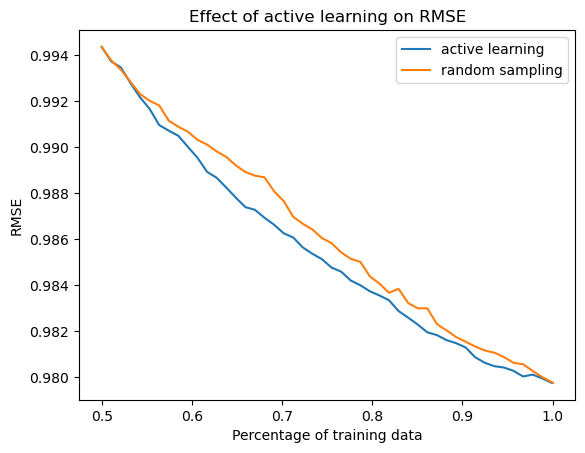

In [15]:
# plot rmse by number of samples
import matplotlib.pyplot as plt
plt.plot(train_percentage_array_a, rmse_array_a, label='active learning')
plt.plot(train_percentage_array, rmse_array, label='random sampling')
plt.legend()
plt.title('Effect of active learning on RMSE')
plt.xlabel('Percentage of training data')
plt.ylabel('RMSE')
plt.savefig('active_learning_export/active_learning_rmse.png')
plt.show()

In [16]:
# save arrays
np.save('active_learning_export/rmse_array_a.npy', rmse_array_a)
np.save('active_learning_export/train_percentage_array_a.npy', train_percentage_array_a)
np.save('active_learning_export/rmse_array.npy', rmse_array)
np.save('active_learning_export/train_percentage_array.npy', train_percentage_array)